Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)          │ (None, 2, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ modified_gru_75 (ModifiedGRU)        │ [(None, 2, 64), (None, 64)] │          21,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ modified_gru_76 (ModifiedGRU)        │ [(None, 2, 64), (None, 64)] │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_37          │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_202 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,659 (213.51 KB)

 Trainable params: 54,659 (213.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.1833 - loss: 1.3783 - val_accuracy: 0.2500 - val_loss: 1.2375
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3875 - loss: 1.1443 - val_accuracy: 0.2500 - val_loss: 1.1611
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4625 - loss: 1.0825 - val_accuracy: 0.2500 - val_loss: 1.1818
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5167 - loss: 1.0313 - val_accuracy: 0.2500 - val_loss: 1.1810
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4708 - loss: 1.0423 - val_accuracy: 0.2500 - val_loss: 1.1244
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5000 - loss: 1.0426 - val_accuracy: 0.2500 - val_loss: 1.1459
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4792 - loss: 1.0454 - val_accuracy: 0.2500 - val_loss: 1.1193
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3958 - loss: 1.0707 - val_accuracy: 0.2500 - val_loss: 1.089

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Classification Report:
                  precision    recall  f1-score   support

Heart Disease 1       1.00      1.00      1.00         2
Heart Disease 2       1.00      1.00      1.00         6
         Normal       1.00      1.00      1.00         2

       accuracy                           1.00        10
      macro avg       1.00      1.00      1.00        10
   weighted avg       1.00      1.00      1.00        10



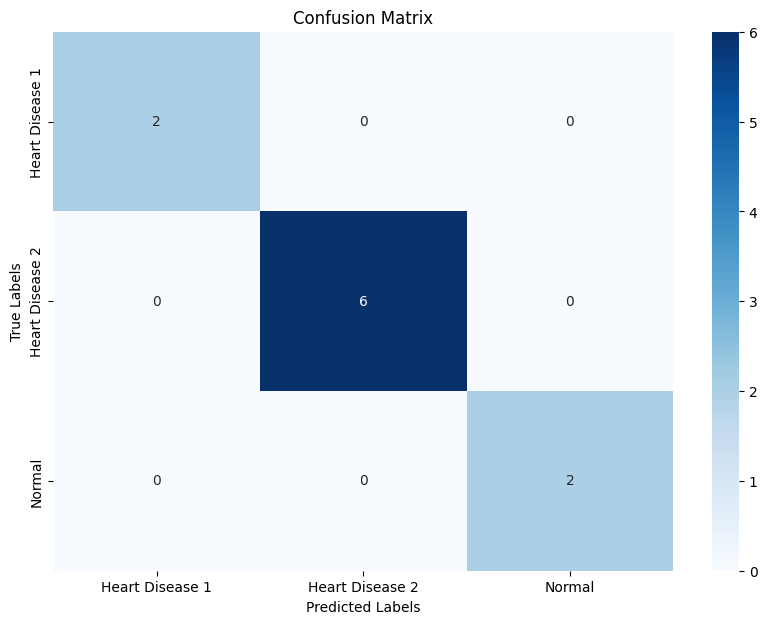

Validation Accuracy: 0.96875


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Self-Attention Layer
class SelfAttention(layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.W = layers.Dense(units)
        self.U = layers.Dense(units)

    def call(self, inputs):
        # Compute attention scores
        score = tf.matmul(inputs, self.W(inputs), transpose_b=True)
        distribution = tf.nn.softmax(score, axis=-1)
        # Apply attention scores
        output = tf.matmul(distribution, self.U(inputs))
        return output + inputs

# Define the Modified GRU Layer with Self-Attention
class ModifiedGRU(layers.Layer):
    def __init__(self, units):
        super(ModifiedGRU, self).__init__()
        self.units = units
        self.gru = layers.GRU(units, return_sequences=True, return_state=True)
        self.attention = SelfAttention(units)

    def call(self, inputs, initial_state=None):
        gru_output, gru_state = self.gru(inputs, initial_state=initial_state)
        attention_output = self.attention(gru_output)
        return attention_output, gru_state

# Define the SAGE-NET Model
def build_sage_net(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Two layers of Modified GRU with Self-Attention
    x, _ = ModifiedGRU(64)(inputs)
    x, _ = ModifiedGRU(64)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ECG/ecg_dataset.csv')

# Extract the features and labels
X = data[['Age', 'ECG Sensor Value']].values
y = data['Diagnosis'].values

# Encode the diagnosis labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# One-hot encode the labels
y = to_categorical(y)

# Reshape the input data to fit the model input shape
X = np.expand_dims(X, axis=-1)  # Shape (samples, features, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
input_shape = (X_train.shape[1], 1)  # Shape (features, 1)
num_classes = y.shape[1]  # Number of unique labels

model = build_sage_net(input_shape, num_classes)

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.2)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)  # Get probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions

# Convert one-hot encoded y_test back to class labels
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
class_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the training accuracy as validation accuracy
print("Validation Accuracy:", history.history['accuracy'][-1])
